# Train ClaDec on the activations of the Classifier
## For the non-perfect version subsets of neurons can be used here

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from src.common import get_mnist_train_test, get_mnist_labels_categorical, load_layer_activations, get_optimizer

from src.common import remove_data_in_last_dim
from src.diffAE.models import SAVED_CLASSIFIER_PATH, SAVED_CLADEC_PATH, get_cladec

tf.random.set_seed(1234)

train_images, test_images = get_mnist_train_test()
train_labels_c, test_labels_c = get_mnist_labels_categorical()

In [2]:
# get the trained model and check accuracy on test data for later reference
classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH)
classifier.evaluate(test_images, test_labels_c)

2022-05-27 16:53:37.790772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 16:53:37.920244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 16:53:37.921438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 16:53:37.924891: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

313/313 [==============================] - 5s 3ms/step - loss: 0.0417 - categorical_accuracy: 0.9863


[0.041650786995887756, 0.986299991607666]

In [3]:
# get the activations (or subsets of it)
layer_subset_percentage = 90
(dense_train_acts, dense_test_acts), (conv_train_acts, conv_test_acts) = load_layer_activations(SAVED_CLASSIFIER_PATH)
if 0 < layer_subset_percentage < 100:
    # remove neurons
    dense_train_acts = remove_data_in_last_dim(dense_train_acts, layer_subset_percentage)
    dense_test_acts = remove_data_in_last_dim(dense_test_acts, layer_subset_percentage)

    conv_train_acts = remove_data_in_last_dim(conv_train_acts, layer_subset_percentage)
    conv_test_acts = remove_data_in_last_dim(conv_test_acts, layer_subset_percentage)

print(dense_test_acts.shape)
print(conv_test_acts.shape)
conv_train_acts.shape

(10000, 9)
(10000, 230)


(60000, 230)

In [4]:
optimizer = get_optimizer()
alpha = 0.0
model_alpha_path = SAVED_CLADEC_PATH.joinpath(f'cladec_{layer_subset_percentage}').joinpath(f'{alpha * 100:2.0f}')
classifier.trainable = False

## ClaDec with decoder for the final Dense layer of up to 10 neurons

In [5]:
model = get_cladec(classifier, alpha, acts_input_shape=dense_train_acts.shape[1:])
model.summary()  # note that the classifier is used in loss but not part of training

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 49)           490         ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 7, 7, 1)      0           ['dense[0][0]']                  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 14, 14, 64)  640         ['reshape[0][0]']                
 ose)                                                                                         

In [6]:
# input for ClaDec and loss function
train_dense_input = [dense_train_acts, train_labels_c, train_images]
test_dense_input = [dense_test_acts, test_labels_c, test_images]
model.compile(optimizer=optimizer)
model.fit(x=train_dense_input, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0790
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0637
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0624
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0621
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0617
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0615
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0613
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0612
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0611
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0610


In [7]:
classifier.evaluate(test_images, test_labels_c)  # same as before - classifier not changed

313/313 [==============================] - 1s 4ms/step - loss: 0.0417 - categorical_accuracy: 0.9863


[0.041650786995887756, 0.986299991607666]

In [8]:
model.evaluate(test_dense_input)

313/313 [==============================] - 1s 4ms/step - loss: 0.0609


0.060883697122335434

In [9]:
# get actual decoder
from keras.models import Model

claDec = Model(model.input[0], model.output)
dense_explain = claDec.predict(dense_test_acts)

In [10]:
claDec.save(model_alpha_path.joinpath('dense'))
claDec.summary()

2022-05-27 16:56:45.035658: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/tom/Uni_Dev/cladec-mnist/saved-models/diffAE/cladec/cladec_90/ 0/dense/assets
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 49)                490       
                                                                 
 reshape (Reshape)           (None, 7, 7, 1)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       640       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        577       
 ranspose)                                                       
      

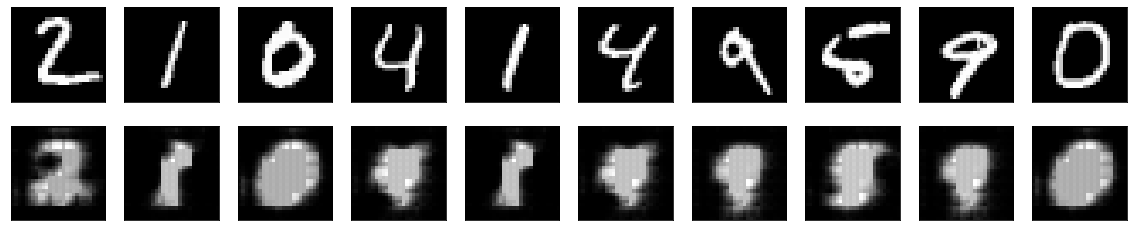

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(dense_explain[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## ClaDec with Decoder for the last convolutional layer of up to 2 x 2 x 64 = 256 neurons

In [12]:
# input for ClaDec and loss function
train_conv_input = [conv_train_acts, train_labels_c, train_images]
test_conv_input = [conv_test_acts, test_labels_c, test_images]
model = get_cladec(classifier, alpha, acts_input_shape=conv_train_acts.shape[1:])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 230)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 49)           11319       ['input_4[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 7, 7, 1)      0           ['dense_1[0][0]']                
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 14, 14, 64)  640         ['reshape_1[0][0]']              
 spose)                                                                                     

In [13]:
model.compile(optimizer=optimizer)
model.fit(x=train_conv_input, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0420
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0308
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0294
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0288
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0283
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0280
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0277
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0275
Epoch 9/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0273
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0272


In [14]:
model.evaluate(test_conv_input)

313/313 [==============================] - 2s 4ms/step - loss: 0.0268


0.02680664323270321

In [15]:
# get actual decoder
claDec = Model(model.input[0], model.output)
conv_explain = claDec.predict(conv_test_acts)
claDec.save(model_alpha_path.joinpath('conv'))

INFO:tensorflow:Assets written to: /home/tom/Uni_Dev/cladec-mnist/saved-models/diffAE/cladec/cladec_90/ 0/conv/assets


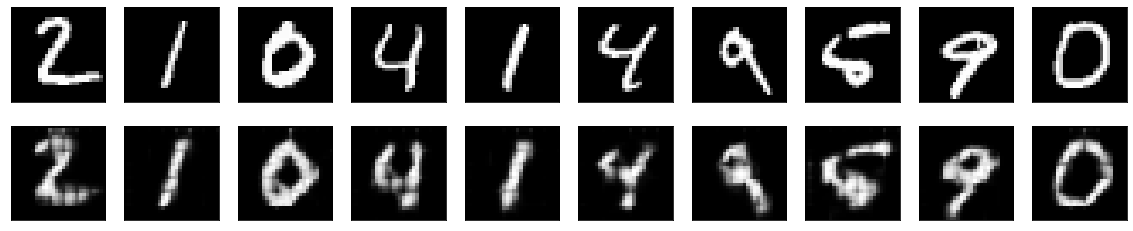

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(conv_explain[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()